In [31]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [32]:
dataset = MNIST(root="data", transform=ToTensor()) #download = True, 
len(dataset)

60000

5


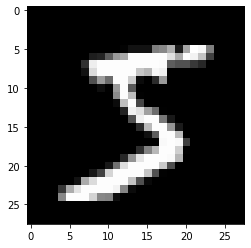

In [33]:
img, label = dataset[0]
plt.imshow(img.squeeze(), cmap='gray') # or img[0]
print(label)

In [34]:
#train_ds = MNIST(root="data", train=True, transform=ToTensor())
#test_ds = MNIST(root="data", train=False, transform=ToTensor())

# or I can decide how to split stuff:
# IN TOTAL I HAVE 60000 IMAGES

validation_size = 10000
train_size = len(dataset) - validation_size

train_ds, val_ds = random_split(dataset, [train_size, validation_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [35]:
batch_size = 100

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [36]:
for xb, yb in train_loader:
    print(xb.shape)
    x1 = xb.view(xb.size(0),-1)
    print(x1.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])


In [37]:
t = torch.tensor([0, .2, -.3])
F.relu(t) # ignoring negative values

tensor([0.0000, 0.2000, 0.0000])

In [38]:
class MnistModel(nn.Module):
    
    def __init__(self, in_size, hidden_size, output_size):
        super().__init__()
        self.linear = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.loss_fn = F.cross_entropy
        
    def forward(self, x):
        # we have 100, 1, 28, 28 and we need 100, 784
        # so we retain the first dimension, which is x.size(0), and we tell pytorch to multiply all the remaining ones
        xb = x.view(x.size(0), -1) 
        
        out = self.linear(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        outs = self.forward(images)
        loss = self.loss_fn(outs, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        outs = self.forward(images)
        validation_loss = self.loss_fn(outs, labels)
        validation_acc = accuracy(outs, labels)
        return {'val_loss': validation_loss, 'val_acc': validation_acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        #print("\n\n\nbatch_losses=", batch_losses)
        epoch_loss = torch.stack(batch_losses).mean()
        
        batch_accs =  [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    

In [39]:
def accuracy(outs, labels):
    _, preds = torch.max(outs, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item()/len(labels)) 
    return acc

In [40]:
input_size = 28*28
hidden_size = 32
num_classes = 10

model = MnistModel(input_size, hidden_size, num_classes)
loss_fn = F.cross_entropy

In [41]:
for batch_imgs, labels in train_loader:
    outs = model(batch_imgs)
    print(outs.shape, labels.shape)
    # cross entropy gestisce da sola la differenza di dimansione tra i due, moltiplicando gli output per il one-hot encoding the label
    loss = loss_fn(outs, labels) 
    print("loss=", loss, loss.item())
    break

torch.Size([100, 10]) torch.Size([100])
loss= tensor(2.3036, grad_fn=<NllLossBackward>) 2.3035738468170166


# Move data to cpu/gpu

In [42]:
torch.cuda.is_available()

False

In [43]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
device = get_device()

In [44]:
rr = torch.tensor([1,2,3])
rr.to(device)

def to_device(data, device):
    #move tensor to device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [45]:
for imgs, labs in train_loader:
    imgs = imgs.to(device)
    break

wrap our existing data loaders and move batches of data to the selected device

In [46]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #yield a batch of data after moving it to device
        #yield pauses the execution of a funcion, so here pauses the for loop:
        #yields return a data, and pauses the func, the next time the func is called, 
        #yield returns the next data batch
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        # num of batches
        return len(self.dl)

In [47]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [48]:
for xb, yb in train_loader:
    print(xb.device)
    print(xb.shape)
    print(yb.device)
    break

cpu
torch.Size([100, 1, 28, 28])
cpu


# Train loop

In [49]:
def evaluate(model, validation_dataloader):
    outs = [model.validation_step(batch) for batch in validation_dataloader]
    #print('outs=', outs)
    return model.validation_epoch_end(outs)

def fit(epochs, lr, model, train_dataloader, validation_dataloader, opt_func = torch.optim.SGD):
    
    history = []
    opt = opt_func(model.parameters(), lr=lr)
    for epoch in range(epochs):
        print("Epoch=", epoch)
        for batch in train_dataloader:
            loss = model.training_step(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        results = evaluate(model, validation_dataloader)
        history.append(results)
            
    return history
        

In [50]:
input_size = 28*28
hidden_size = 32
num_classes = 10

model = MnistModel(input_size, hidden_size, num_classes)
to_device(model, device)

MnistModel(
  (linear): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [52]:
history = [evaluate(model, val_loader)]
#history

In [53]:
epochs = 5
lr = 0.5
history += fit(epochs, lr, model, train_loader, val_loader)

Epoch= 0
Epoch= 1
Epoch= 2
Epoch= 3
Epoch= 4


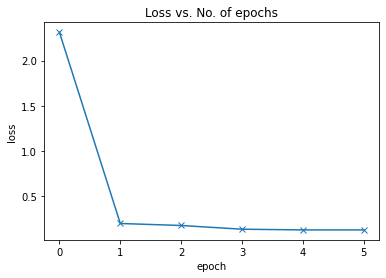

In [54]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

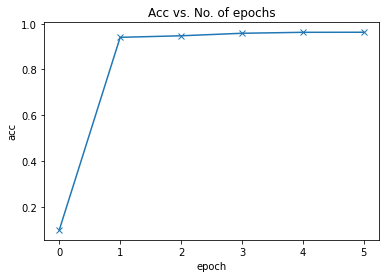

In [55]:
losses = [x['val_acc'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Acc vs. No. of epochs');

# predicting some images

In [56]:
test_ds = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [57]:
def predict_img(img, model):
    img = to_device(img.unsqueeze(0), device)
    out = model(img)
    _, pred = torch.max(out, dim=1)
    return pred.item()

Label= 7 , Predicted= 7


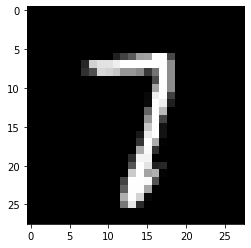

In [58]:
img, label = test_ds[234]
plt.imshow(img[0], cmap='gray')

out = predict_img(img, model)
print("Label=", label, ", Predicted=", out)

Label= 0 , Predicted= 0


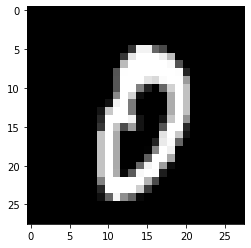

In [61]:
img, label = test_ds[346]
plt.imshow(img[0], cmap='gray')

out = predict_img(img, model)
print("Label=", label, ", Predicted=", out)

# other stuff

In [59]:
def train_loop(epochs, lr, model, train_dl, valid_dl, loss_fn, opt=None, metric=None):
    
    losses = []
    metrics = []
    
    if opt is None: opt_fn = torch.optim.SGD()
    opt = opt_fn(model.parameters(), lr=lr)

    for epoch in range(epochs):
        
        # train step
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)
            
        # evaluation step
        val_loss, total, val_metric = evaluate(model, loss_fn, valid_dl, metric)
        
        losses.append(val_loss)
        metrics.append(val_metric)
        
        if metric is None:
            print("epoch=", epoch, "valid loss=", val_loss)
        else:
            print("epoch=", epoch, "valid loss=", val_loss, 'metric=', val_metric)

In [60]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, opt=None, metric=metric) 
                   for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        total = np.sum(nums)
        avg_losses = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
        
        return avg_losses, total, avg_metric